In [1]:
# TODO: imports
import numpy as np
import torch
import gpytorch
from easygpr import GPRModel
import matplotlib.pyplot as plt
import easygpr.utils as utils

from easygpr.utils.settings import set_gpytorch_settings

set_gpytorch_settings()


ModuleNotFoundError: No module named 'utils'

Mat52
Fitting complete.
--- 
--- final mll: -1.9413
--- num_params: 4
--- BIC: 15.8654
Mat52
Fitting complete.
--- 
--- final mll: -2.0134
--- num_params: 4
--- BIC: 16.0097
Mat52
Fitting complete.
--- 
--- final mll: -1.8693
--- num_params: 4
--- BIC: 15.7214
tensor([[0.0500]])
tensor([[2.]])
tensor([[0.1106]], grad_fn=<SoftplusBackward0>)
tensor(1.8942, grad_fn=<SoftplusBackward0>)
tensor(10.)
tensor(2.0498, grad_fn=<SoftplusBackward0>)
tensor([1.4848], grad_fn=<AddBackward0>)
tensor([1.9704], grad_fn=<AddBackward0>)
tensor([1.6254], grad_fn=<AddBackward0>)
tensor([[-9.0112e-02],
        [-7.8837e-02],
        [-6.7562e-02],
        [-5.6287e-02],
        [-4.5012e-02],
        [-3.3737e-02],
        [-2.2462e-02],
        [-1.1186e-02],
        [ 8.8812e-05],
        [ 1.1364e-02],
        [ 2.2639e-02],
        [ 3.3914e-02],
        [ 4.5189e-02],
        [ 5.6465e-02],
        [ 6.7740e-02],
        [ 7.9015e-02],
        [ 9.0290e-02],
        [ 1.0157e-01],
        [ 1.1284e-01

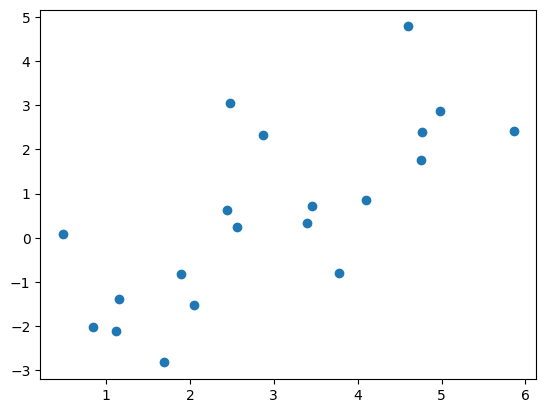

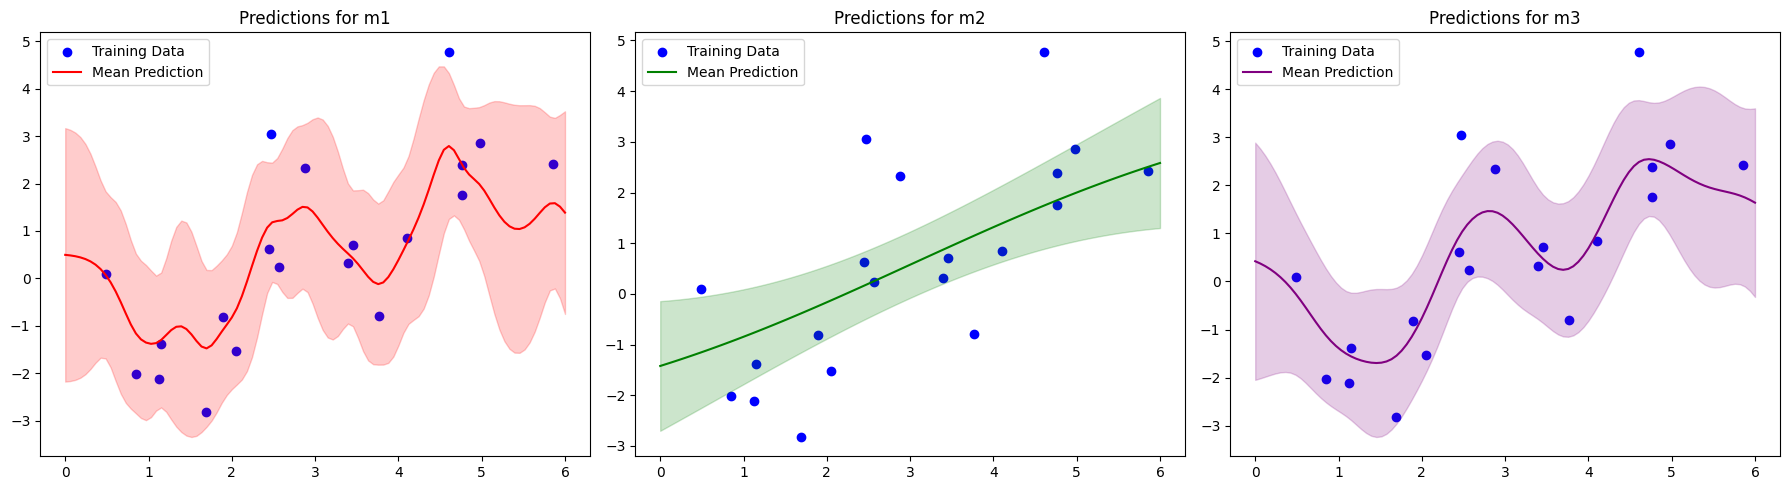

Fitting complete.
--- 
--- final mll: -1.9372
--- num_params: 4
--- BIC: 15.8574


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [2]:
# Unused synthetic example
seed = 4787510

torch.manual_seed(seed)
np.random.seed(seed)



# Define the underlying function
def f(x):
    return x + np.sin(x * 3) - 3


# Generate synthetic training data with noise
x_train = np.random.uniform(0, 1, 20) + np.linspace(0, 5, 20)
y_train = f(x_train) + np.random.normal(0, 1, x_train.shape)

plt.scatter(x_train, y_train)

m1 = GPRModel(train_x=x_train, train_y=y_train, kernel="Mat52")
m1.covar_module.base_kernel.lengthscale = 0.05
m1.covar_module.base_kernel.raw_lengthscale.requires_grad = False
m1.fit_model()

m2 = GPRModel(train_x=x_train, train_y=y_train, kernel="Mat52")
m2.covar_module.base_kernel.lengthscale = 2
m2.covar_module.base_kernel.raw_lengthscale.requires_grad = False
m2.covar_module.outputscale = 10
m2.covar_module.raw_outputscale.requires_grad = False
m2.fit_model()

m3 = GPRModel(train_x=x_train, train_y=y_train, kernel="Mat52")
m3.fit_model()

print(m1.covar_module.base_kernel.lengthscale)
print(m2.covar_module.base_kernel.lengthscale)
print(m3.covar_module.base_kernel.lengthscale)

print(m1.covar_module.outputscale)
print(m2.covar_module.outputscale)
print(m3.covar_module.outputscale)

print(m1.likelihood.noise)
print(m2.likelihood.noise)
print(m3.likelihood.noise)

# Create a range of test inputs for predictions
x_test = torch.linspace(0, 6, 100)

# Make predictions for m1
predictions_m1 = m1.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Make predictions for m2
predictions_m2 = m2.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Make predictions for m3
predictions_m3 = m3.make_predictions(x_test.unsqueeze(1), type="f",
                                     return_type="numpy")  # Assuming you have a model named m3

# Create a 1x3 subplot layout for the predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figsize to accommodate the third panel

# Plot predictions for m1
axes[0].set_title('Predictions for m1')
axes[0].scatter(x_train, y_train, label='Training Data', color='blue')
axes[0].plot(utils.to_numpy(x_test), predictions_m1.mean, label='Mean Prediction', color='red')
axes[0].fill_between(utils.to_numpy(x_test), predictions_m1.mean - 1.96 * np.sqrt(predictions_m1.variance),
                     predictions_m1.mean + 1.96 * np.sqrt(predictions_m1.variance), alpha=0.2, color='red')
axes[0].legend()

# Plot predictions for m2
axes[1].set_title('Predictions for m2')
axes[1].scatter(x_train, y_train, label='Training Data', color='blue')
axes[1].plot(utils.to_numpy(x_test), predictions_m2.mean, label='Mean Prediction', color='green')
axes[1].fill_between(utils.to_numpy(x_test), predictions_m2.mean - 1.96 * np.sqrt(predictions_m2.variance),
                     predictions_m2.mean + 1.96 * np.sqrt(predictions_m2.variance), alpha=0.2, color='green')
axes[1].legend()

# Plot predictions for m3
axes[2].set_title('Predictions for m3')  # Set the title for the third panel
axes[2].scatter(x_train, y_train, label='Training Data', color='blue')
axes[2].plot(utils.to_numpy(x_test), predictions_m3.mean, label='Mean Prediction',
             color='purple')  # Adjust color and label for m3
axes[2].fill_between(utils.to_numpy(x_test), predictions_m3.mean - 1.96 * np.sqrt(predictions_m3.variance),
                     predictions_m3.mean + 1.96 * np.sqrt(predictions_m3.variance), alpha=0.2,
                     color='purple')  # Adjust color for m3
axes[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

m1.fit_model()


Mat52
Mat52
Mat52
Fitting complete.
--- 
--- final mll: -1.4444
--- num_params: 4
--- BIC: 18.6161
tensor([[0.0000],
        [0.0121],
        [0.0242],
        [0.0364],
        [0.0485],
        [0.0606],
        [0.0727],
        [0.0848],
        [0.0970],
        [0.1091],
        [0.1212],
        [0.1333],
        [0.1455],
        [0.1576],
        [0.1697],
        [0.1818],
        [0.1939],
        [0.2061],
        [0.2182],
        [0.2303],
        [0.2424],
        [0.2545],
        [0.2667],
        [0.2788],
        [0.2909],
        [0.3030],
        [0.3152],
        [0.3273],
        [0.3394],
        [0.3515],
        [0.3636],
        [0.3758],
        [0.3879],
        [0.4000],
        [0.4121],
        [0.4242],
        [0.4364],
        [0.4485],
        [0.4606],
        [0.4727],
        [0.4848],
        [0.4970],
        [0.5091],
        [0.5212],
        [0.5333],
        [0.5455],
        [0.5576],
        [0.5697],
        [0.5818],
        [0.5939],
 

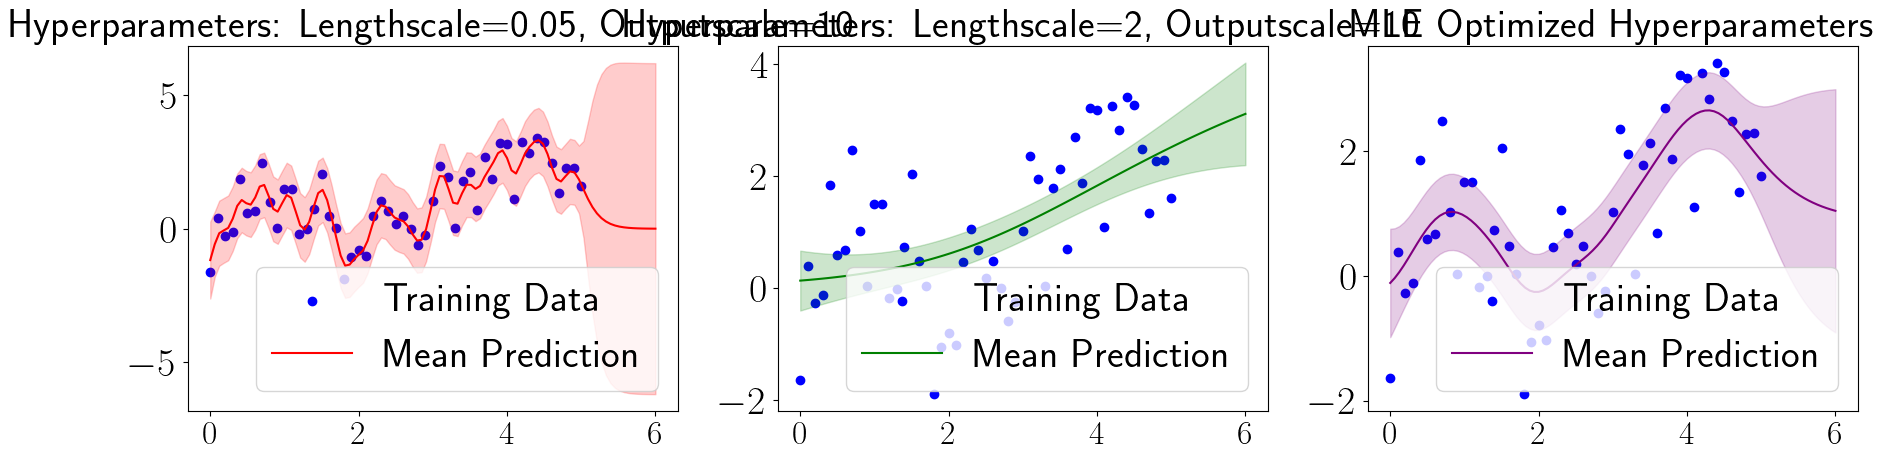

In [10]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from easygpr import GPRModel, utils
import matplotlib.pyplot as plt

# Seed for reproducibility
seed = 235789
torch.manual_seed(seed)
np.random.seed(seed)

# Define the underlying function
def f(x):
    return 0.1 * x ** 2 + np.sin(x * 2)

# Generate synthetic training data with noise
x_train = np.linspace(0, 5, 51)
y_train = f(x_train) + np.random.normal(0, 1, x_train.shape)

# Generate an additional 50 points as test set
x_test = np.linspace(0, 6, 100)
y_test = f(x_test) + np.random.normal(0, 1, x_test.shape)

# Convert to PyTorch tensors and scale data
scaler = MinMaxScaler()
scaler.fit(x_train.reshape(-1, 1))

train_x = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)

train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)
train_x_std = torch.tensor(scaler.transform(train_x.cpu()), dtype=torch.float32)
test_x_std = torch.tensor(scaler.transform(test_x.cpu()), dtype=torch.float32)

# Define models with varying hyperparameters
m1 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m1.covar_module.base_kernel.lengthscale = 0.05
m1.covar_module.outputscale = 10

m2 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m2.covar_module.base_kernel.lengthscale = 2
m2.covar_module.outputscale = 10

m3 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m3.fit_model(training_iterations=500, cosine_annealing=True)



# Function to make predictions and plot
def make_plot(model, ax, color, title):
    predictions = model.make_predictions(test_x_std, type="f", return_type="numpy")
    ax.scatter(x_train, y_train, label='Training Data', color='blue')
    ax.plot(x_test, predictions.mean, label='Mean Prediction', color=color)
    ax.fill_between(x_test, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color)
    ax.set_title(title)
    ax.legend()

# Create subplot layout and plot predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
make_plot(m1, axes[0], 'red', 'Hyperparameters: Lengthscale=0.05, Outputscale=10')
make_plot(m2, axes[1], 'green', 'Hyperparameters: Lengthscale=2, Outputscale=10')
make_plot(m3, axes[2], 'purple', 'MLE Optimized Hyperparameters')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('path_to_the_posterior_hyperparameters_plot.png', dpi=300)




In [11]:
from sklearn.metrics import mean_squared_error
import pandas as pd

m4 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Exponential")
m4.fit_model(training_iterations=500, cosine_annealing=True)

# Function to calculate RMSE and BIC
def calculate_metrics(model, train_x, train_y, test_x, test_y):
    train_pred = model.make_predictions(train_x, type="f", return_type="numpy")
    test_pred = model.make_predictions(test_x, type="f", return_type="numpy")
    
    train_rmse = np.sqrt(mean_squared_error(train_y.cpu().numpy(), train_pred.mean))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred.mean))
    
    bic = model.bic
    
    return train_rmse, test_rmse, bic

# Gather metrics and hyperparameters for table
models = [m1, m2, m3, m4]
data = []
for i, model in enumerate(models, 1):
    lengthscale = round(model.covar_module.base_kernel.lengthscale.item(), 4)
    outputscale = round(model.covar_module.outputscale.item(), 4)
    noise = round(model.likelihood.noise.item(), 4)
    model.compute_bic()
    train_rmse, test_rmse, bic = calculate_metrics(model, train_x_std, train_y, test_x_std, y_test)
    bic = bic.item()
    data.append([f'm{i}', lengthscale, outputscale, noise, round(bic, 4), round(train_rmse, 4), round(test_rmse, 4)])

# Create a DataFrame
df = pd.DataFrame(data, columns=["Model", "Lengthscale", "Outputscale", "Noise", "BIC", "Train RMSE", "Test RMSE"])

# Convert the DataFrame to a LaTeX table
print(df.to_latex(index=False))


Exponential
Fitting complete.
--- 
--- final mll: -1.4385
--- num_params: 4
--- BIC: 18.6042
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800],
        [0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800],
       

tensor([[0.0000],
        [0.0121],
        [0.0242],
        [0.0364],
        [0.0485],
        [0.0606],
        [0.0727],
        [0.0848],
        [0.0970],
        [0.1091],
        [0.1212],
        [0.1333],
        [0.1455],
        [0.1576],
        [0.1697],
        [0.1818],
        [0.1939],
        [0.2061],
        [0.2182],
        [0.2303],
        [0.2424],
        [0.2545],
        [0.2667],
        [0.2788],
        [0.2909],
        [0.3030],
        [0.3152],
        [0.3273],
        [0.3394],
        [0.3515],
        [0.3636],
        [0.3758],
        [0.3879],
        [0.4000],
        [0.4121],
        [0.4242],
        [0.4364],
        [0.4485],
        [0.4606],
        [0.4727],
        [0.4848],
        [0.4970],
        [0.5091],
        [0.5212],
        [0.5333],
        [0.5455],
        [0.5576],
        [0.5697],
        [0.5818],
        [0.5939],
        [0.6061],
        [0.6182],
        [0.6303],
        [0.6424],
        [0.6545],
        [0

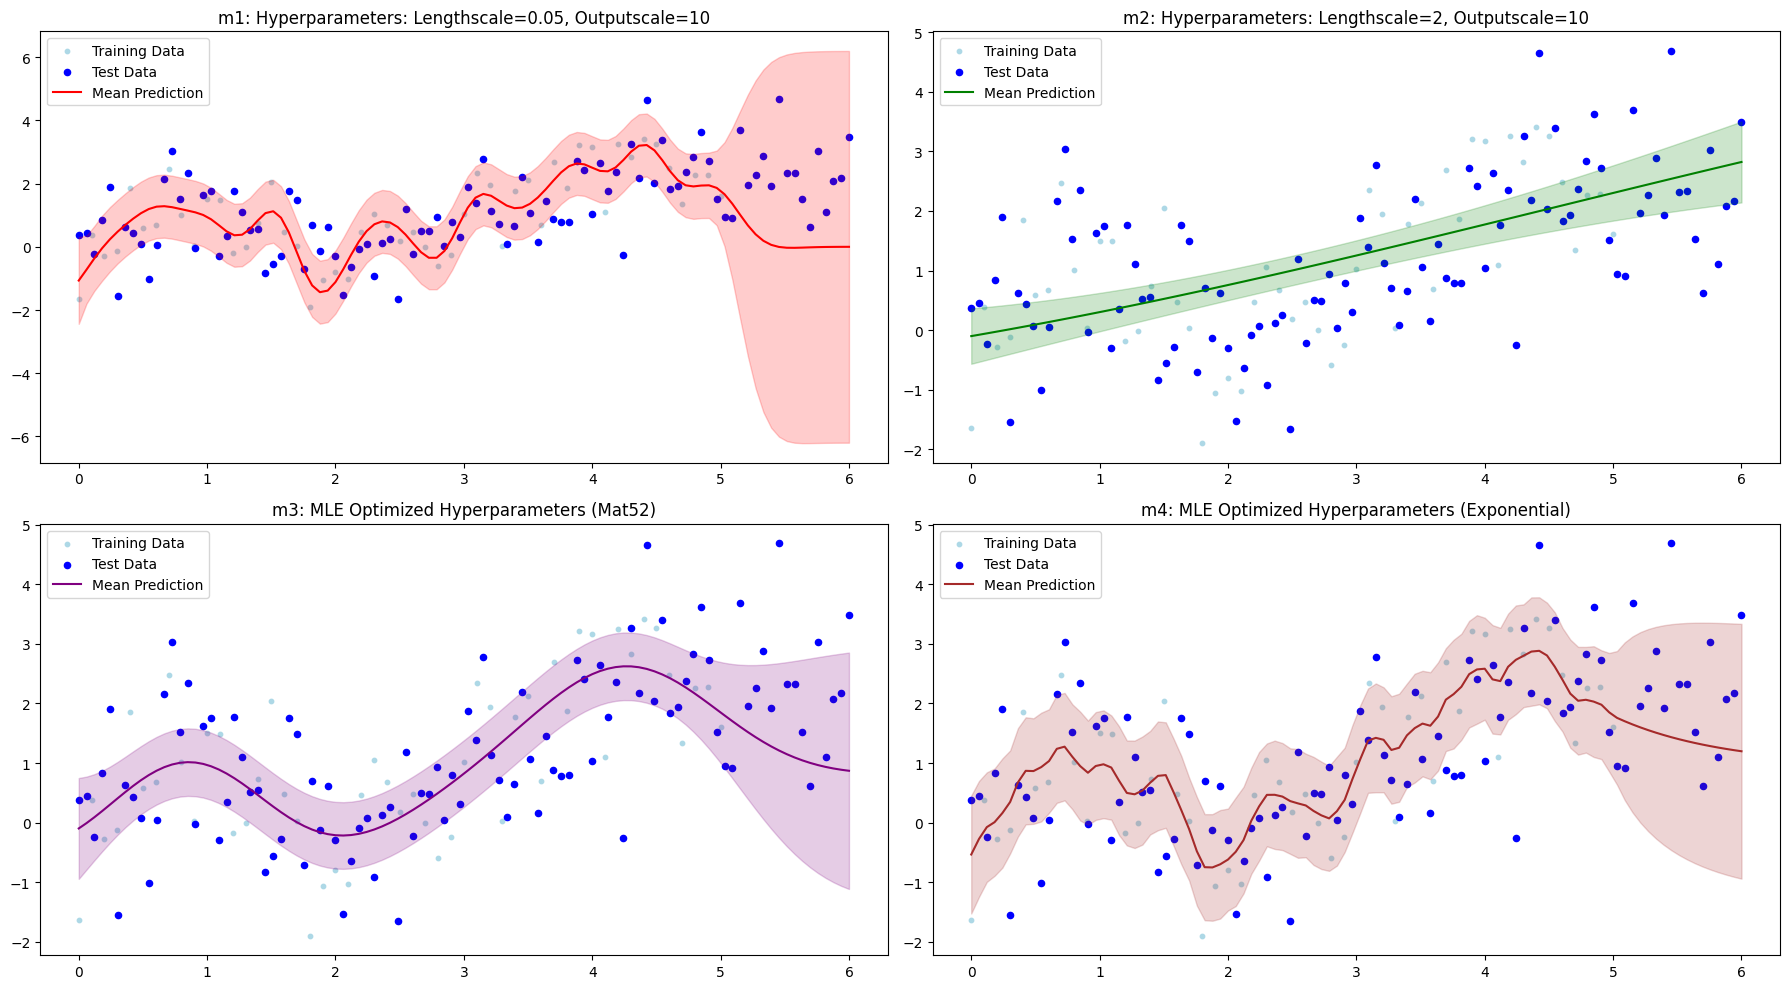

In [5]:

# Function to make enhanced plots utilizing both training and test sets
def make_enhanced_plot(model, ax, color, title):
    predictions = model.make_predictions(test_x_std, type="f", return_type="numpy")
    ax.scatter(x_train, y_train, label='Training Data', color='lightblue', s=10)
    ax.scatter(x_test, y_test, label='Test Data', color='blue', s=20)
    ax.plot(x_test, predictions.mean, label='Mean Prediction', color=color)
    ax.fill_between(x_test, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color)
    ax.set_title(title)
    ax.legend()

# Create subplot layout and plot predictions with enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
make_enhanced_plot(m1, axes[0, 0], 'red', 'm1: Hyperparameters: Lengthscale=0.05, Outputscale=10')
make_enhanced_plot(m2, axes[0, 1], 'green', 'm2: Hyperparameters: Lengthscale=2, Outputscale=10')
make_enhanced_plot(m3, axes[1, 0], 'purple', 'm3: MLE Optimized Hyperparameters (Mat52)')
make_enhanced_plot(m4, axes[1, 1], 'brown', 'm4: MLE Optimized Hyperparameters (Exponential)')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('enhanced_posterior_hyperparameters_plot.png', dpi=300)

In [6]:
from matplotlib.lines import Line2D

plt.rcParams['text.usetex'] = True

# Update plot parameters to increase font sizes and other style settings
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'x-large',
          'font.size': 20,
          'text.usetex': True}
import matplotlib.pylab as pylab
pylab.rcParams.update(params)



# Function to make enhanced plots utilizing both training and test sets
def make_enhanced_plot(models, ax, colors, title, emphasize_test_data=True, include_confidence_bands=False):
    # Generate a mesh of 200 points for smooth predictions
    x_mesh = np.linspace(0, 6, 200)
    x_mesh_std = torch.tensor(scaler.transform(x_mesh.reshape(-1, 1)), dtype=torch.float32)
    
    # Define the true underlying function
    f_0 = 0.1 * x_mesh**2 + np.sin(2 * x_mesh)
    ax.plot(x_mesh, f_0, color='grey', linestyle='-', linewidth=1, label='$f_0(x) = 0.1x^2 + \sin(2x)$')
    
    # Change marker size to emphasize different datasets in each panel
    ax.scatter(x_train, y_train, label='Training', color='blue', s=30, marker='o')
    ax.scatter(x_test, y_test, label='Test', color='green', s=30, marker='x')
    
    # Exclude edge points and select 10 roughly equally spaced indices
    selected_indices = np.linspace(5, len(x_test) - 6, 10, dtype=int)
    
    for model, color in zip(models, colors):
        predictions_f = model.make_predictions(x_mesh_std, type="f", return_type="numpy")
        predictions_y = model.make_predictions(x_mesh_std, type="y", return_type="numpy")
        ax.plot(x_mesh, predictions_f.mean, label=f'{model.name}', color=color, linewidth=2)
        
        if include_confidence_bands:
            ax.fill_between(x_mesh, predictions_f.mean - 1.96 * np.sqrt(predictions_f.variance),
                            predictions_f.mean + 1.96 * np.sqrt(predictions_f.variance), alpha=0.2, color=color,
                            label='95\% CI for f')
            ax.fill_between(x_mesh, predictions_y.mean - 1.96 * np.sqrt(predictions_y.variance),
                            predictions_y.mean + 1.96 * np.sqrt(predictions_y.variance), alpha=0.2, color=color,
                            linestyle='dashed', label='95\% PI for y')
        
        # Adding residuals for a subset of the test data in the right plot
        if len(models) == 1:
            for idx in selected_indices:
                x_val, y_val = x_test[idx], y_test[idx]
                y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
                ax.plot([x_val, x_val], [y_val, y_pred], color='darkgrey', linestyle='--', linewidth=1.5)
    
    ax.set_title(title)




tensor([[0.0000],
        [0.0060],
        [0.0121],
        [0.0181],
        [0.0241],
        [0.0302],
        [0.0362],
        [0.0422],
        [0.0482],
        [0.0543],
        [0.0603],
        [0.0663],
        [0.0724],
        [0.0784],
        [0.0844],
        [0.0905],
        [0.0965],
        [0.1025],
        [0.1085],
        [0.1146],
        [0.1206],
        [0.1266],
        [0.1327],
        [0.1387],
        [0.1447],
        [0.1508],
        [0.1568],
        [0.1628],
        [0.1688],
        [0.1749],
        [0.1809],
        [0.1869],
        [0.1930],
        [0.1990],
        [0.2050],
        [0.2111],
        [0.2171],
        [0.2231],
        [0.2291],
        [0.2352],
        [0.2412],
        [0.2472],
        [0.2533],
        [0.2593],
        [0.2653],
        [0.2714],
        [0.2774],
        [0.2834],
        [0.2894],
        [0.2955],
        [0.3015],
        [0.3075],
        [0.3136],
        [0.3196],
        [0.3256],
        [0

C:\Users\jrisk\AppData\Local\Temp\ipykernel_5320\1460368635.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
C:\Users\jrisk\AppData\Local\Temp\ipykernel_5320\1460368635.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
C:\Users\jrisk\AppData\Local\Temp\ipykernel_5320\1460368635.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is dep

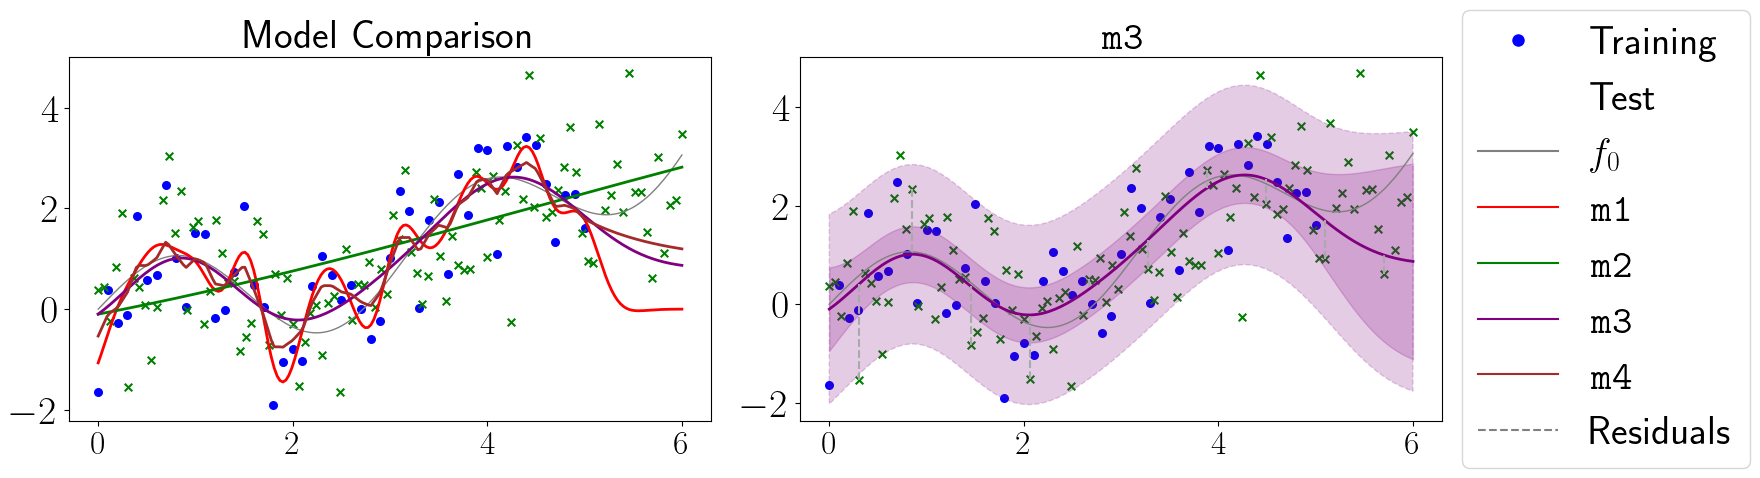

In [7]:
# Create subplot layout and plot predictions with enhanced visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Set names for the models for easier referencing in the plot labels
m1.name, m2.name, m3.name, m4.name = '\\texttt{m1}', '\\texttt{m2}', '\\texttt{m3}', '\\texttt{m4}'

make_enhanced_plot([m1, m2, m3, m4], axes[0], ['red', 'green', 'purple', 'brown'], 'Model Comparison', emphasize_test_data=False)
make_enhanced_plot([m3], axes[1], ['purple'], '\\texttt{m3}', include_confidence_bands=True)

# Custom handles for unified legend
custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Training', markersize=10, markerfacecolor='blue'), 
    Line2D([0], [0], marker='x', color='w', label='Test', markersize=10, markerfacecolor='green'), 
    Line2D([0], [0], linestyle='-', color='grey', label='$f_0$'),
    Line2D([0], [0], linestyle='-', color='red', label='\\texttt{m1}'),
    Line2D([0], [0], linestyle='-', color='green', label='\\texttt{m2}'),
    Line2D([0], [0], linestyle='-', color='purple', label='\\texttt{m3}'),
    Line2D([0], [0], linestyle='-', color='brown', label='\\texttt{m4}'),
    Line2D([0], [0], linestyle='--', color='gray', linewidth=1.5, label='Residuals')
]

# Adding unified legend
axes[1].legend(handles=custom_handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('enhanced_posterior_hyperparameters_plot.png', dpi=300)

rbf
Fitting complete.
--- 
--- final mll: -1.6312
--- num_params: 4
--- BIC: 15.2449
rbf
Fitting complete.
--- 
--- final mll: -1.5050
--- num_params: 4
--- BIC: 25.0958
tensor([[0.0000],
        [0.0121],
        [0.0242],
        [0.0364],
        [0.0485],
        [0.0606],
        [0.0727],
        [0.0848],
        [0.0970],
        [0.1091],
        [0.1212],
        [0.1333],
        [0.1455],
        [0.1576],
        [0.1697],
        [0.1818],
        [0.1939],
        [0.2061],
        [0.2182],
        [0.2303],
        [0.2424],
        [0.2545],
        [0.2667],
        [0.2788],
        [0.2909],
        [0.3030],
        [0.3152],
        [0.3273],
        [0.3394],
        [0.3515],
        [0.3636],
        [0.3758],
        [0.3879],
        [0.4000],
        [0.4121],
        [0.4242],
        [0.4364],
        [0.4485],
        [0.4606],
        [0.4727],
        [0.4848],
        [0.4970],
        [0.5091],
        [0.5212],
        [0.5333],
        [0.5455],
  

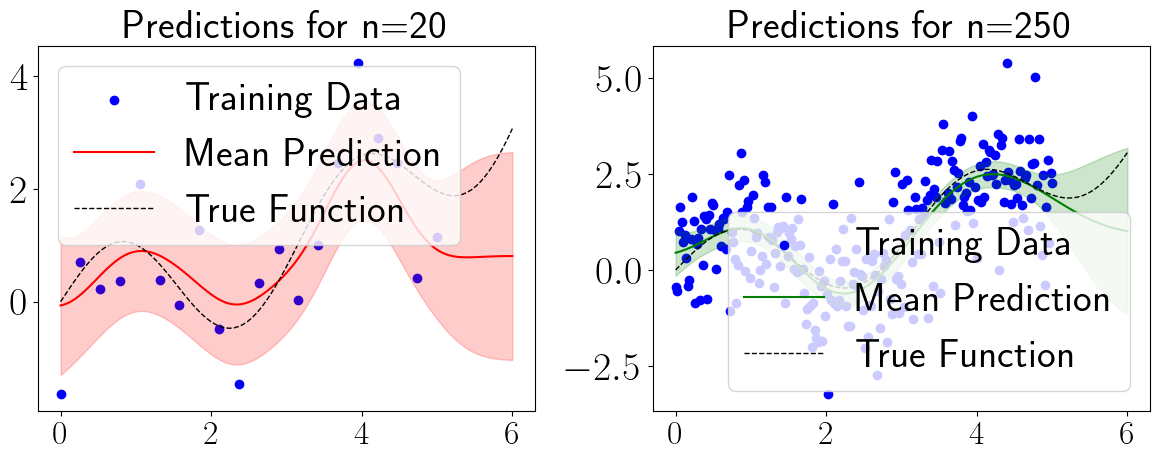

In [8]:

seed = 235789

torch.manual_seed(seed)
np.random.seed(seed)


# Define the underlying function
def f(x):
    return 0.1 * x ** 2 + np.sin(x * 2)


# Generate synthetic training data with noise for n=20
x_train_20 = np.linspace(0, 5, 20)
y_train_20 = f(x_train_20) + np.random.normal(0, 1, x_train_20.shape)

# Generate synthetic training data with noise for n=250
x_train_250 = np.linspace(0, 5, 250)
y_train_250 = f(x_train_250) + np.random.normal(0, 1, x_train_250.shape)

# Create a range of test inputs
x_test = torch.linspace(0, 6, 100)

# Create GPR models for n=20 and n=250
m_20 = GPRModel(train_x=x_train_20, train_y=y_train_20, kernel="rbf")

m_20.fit_model()

m_250 = GPRModel(train_x=x_train_250, train_y=y_train_250, kernel="rbf")

m_250.fit_model()

# Make predictions for n=20 and n=250
predictions_20 = m_20.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_250 = m_250.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Create a 1x2 subplot layout for the predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x_test = utils.to_numpy(x_test)

# Plot predictions for n=20
axes[0].set_title('Predictions for n=20')
axes[0].scatter(x_train_20, y_train_20, label='Training Data', color='blue')
axes[0].plot(x_test, predictions_20.mean, label='Mean Prediction', color='red')
axes[0].fill_between(x_test, predictions_20.mean - 1.96 * np.sqrt(predictions_20.variance),
                     predictions_20.mean + 1.96 * np.sqrt(predictions_20.variance), alpha=0.2, color='red')
axes[0].plot(x_test, f(x_test), '--', label='True Function', color='black', linewidth=1)
axes[0].legend()

# Plot predictions for n=250
axes[1].set_title('Predictions for n=250')
axes[1].scatter(x_train_250, y_train_250, label='Training Data', color='blue')
axes[1].plot(x_test, predictions_250.mean, label='Mean Prediction', color='green')
axes[1].fill_between(x_test, predictions_250.mean - 1.96 * np.sqrt(predictions_250.variance),
                     predictions_250.mean + 1.96 * np.sqrt(predictions_250.variance), alpha=0.2, color='green')
axes[1].plot(x_test, f(x_test), '--', label='True Function', color='black', linewidth=1)
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as synthetic1_GP-n20-vs-250.png
plt.savefig('synthetic1_GP-n20-vs-250.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()





